Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[7.51232 153.878; 8.42462 155.079; … ; 7.40551 154.76; 7.69881 154.416]

Union{Missing, Float64}[7.71972 154.242; 7.73855 154.083; … ; 7.73092 154.855; 7.72672 154.898]

Union{Missing, Float64}[7.69901 154.278; 8.30787 155.218; … ; 7.81918 153.794; 7.95927 155.492]

Union{Missing, Float64}[7.60864 154.734; 7.14235 155.196; … ; 7.72404 154.569; 7.87691 154.264]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
          Mean        SD       Naive SE       MCSE     ESS
sigma   7.7775086 0.29272293 0.0046283560 0.004856116 1000
   mu 154.6121220 0.40911782 0.0064687207 0.006264841 1000

Quantiles:
         2.5%      25.0%     50.0%      75.0%       97.5%  
sigma   7.230598   7.57478   7.76427   7.9675925   8.385025
   mu 153.791875 154.34700 154.61800 154.8912500 155.380075



Plot the density of posterior draws

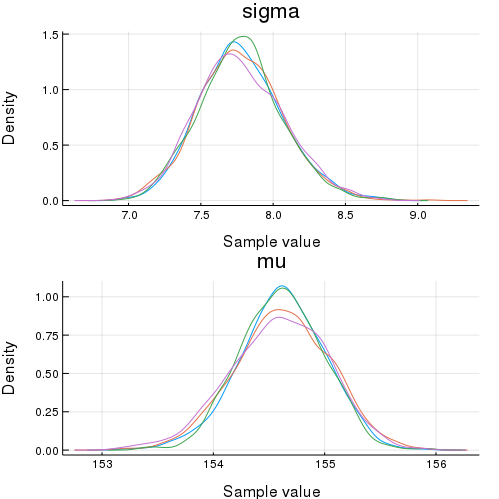

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.15082298408408393
 0.08384692362672422

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
 1.0        0.0790845
 0.0790845  1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*